In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


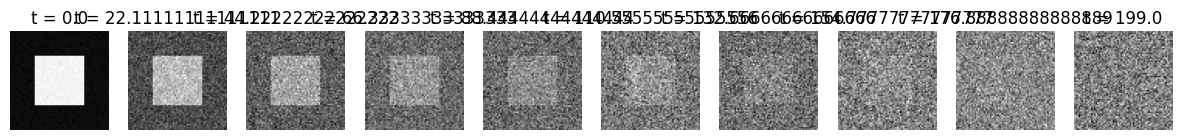

In [2]:
# Load or create a 2D image (grayscale)
image_size = 64  # 64x64 pixels
timesteps = 200  # Number of diffusion steps

# Create a sample 2D image (a square in the middle)
image = torch.zeros((image_size, image_size))
image[16:48, 16:48] = 1.0  # A white square

# Convert to tensor and add batch/channel dimensions
image = image.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 64, 64)

scheduler = diffusers.DDPMScheduler(num_train_timesteps=timesteps, beta_schedule="squaredcos_cap_v2")

fig, axes = plt.subplots(1, 10, figsize=(15, 3))

steps = np.linspace(0, timesteps-1, 10)

for i, t in enumerate(steps):
    timestep_tensor = torch.tensor([t], dtype=torch.long)
    noisy_image = scheduler.add_noise(image, torch.randn_like(image), timestep_tensor)
    axes[i].imshow(noisy_image.squeeze().numpy(), cmap="gray")
    axes[i].set_title(f"t = {t}")
    axes[i].axis("off")

plt.show()

In [3]:
transformation = transforms.Compose([transforms.Normalize((0.5), (0.5))])
normImg = transformation(image)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define a linear noise schedule
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
alphas = 1 - betas
alpha_hat = torch.cumprod(alphas, dim=0)  # cumulative product over timesteps

# ------------------------------
# 3. Build a Simple Diffusion Model
# ------------------------------
# This simple model is not a full U-Net but serves the purpose for a toy example.
class SimpleDenoiseModel(nn.Module):
    def __init__(self, in_channels=1, time_emb_dim=128):
        super(SimpleDenoiseModel, self).__init__()
        # Time embedding network (conditioning on timestep)
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        # A simple convolutional encoder-decoder network
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, in_channels, kernel_size=3, padding=1)
        # A fully-connected layer to project the time embedding into a feature map
        self.fc = nn.Linear(time_emb_dim, 128 * image_size * image_size)
        
    def forward(self, x, t):
        """
        x: Noisy image of shape (B, C, H, W)
        t: normalized timestep tensor of shape (B,) with values in [0,1]
        """
        # Embed time
        t = t.unsqueeze(-1)  # shape (B, 1)
        t_emb = self.time_embed(t)  # shape (B, time_emb_dim)
        
        # Process image
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        
        # Project time embedding and reshape to add into the convolutional feature map
        B, _, H, W = h.shape
        time_feature = self.fc(t_emb).view(B, 128, H, W)
        h = h + time_feature
        
        h = F.relu(self.conv3(h))
        out = self.conv4(h)
        return out

# Instantiate the model and optimizer
model = SimpleDenoiseModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# ------------------------------
# 4. Training the Diffusion Model
# ------------------------------
epochs = 1000  # You can adjust the number of epochs

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Sample a random timestep t for the current training step (for our batch of 1)
    t = torch.randint(0, timesteps, (1,), device=device)  # shape: (1,)
    
    # Extract the corresponding alpha_hat and reshape for broadcasting
    alpha_hat_t = alpha_hat[t].view(-1, 1, 1, 1)
    
    # Sample random noise
    noise = torch.randn_like(image)
    
    # Create the noisy image at timestep t using the forward process:
    #   x_t = sqrt(alpha_hat_t)*x0 + sqrt(1 - alpha_hat_t)*noise
    
    alpha_hat_t = alpha_hat_t.to(device)
    noisy_image = torch.sqrt(alpha_hat_t) * image + torch.sqrt(1 - alpha_hat_t) * noise
    
    # Normalize t for input to the network (e.g., in the range [0,1])
    t_normalized = t.float() / timesteps
    
    # Model prediction: predict the noise added
    pred_noise = model(noisy_image, t_normalized)
    
    # Loss: Mean Squared Error between the predicted noise and the true noise
    loss = F.mse_loss(pred_noise, noise)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

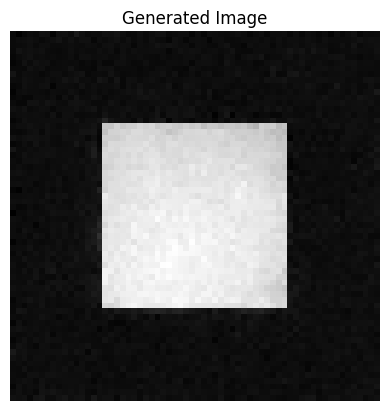

In [21]:
# ------------------------------
# 5. Sampling: Reverse Diffusion Process
# ------------------------------
# Once trained, we can generate (or “denoise”) an image starting from pure noise.
model.eval()
with torch.no_grad():
    # Start from pure Gaussian noise
    x = torch.randn_like(image).to(device)
    
    # Reverse diffusion process: iterate from t = T-1 down to t = 0
    for t in reversed(range(timesteps)):
        # Create a tensor for the current timestep, normalized
        t_tensor = torch.tensor([t], device=device).float() / timesteps
        
        # Extract parameters for current timestep
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_hat_t = alpha_hat[t]
        
        # Predict noise at this timestep
        pred_noise = model(x, t_tensor)
        
        # Estimate the denoised image (x0) from the model prediction
        x0_pred = (x - torch.sqrt(1 - alpha_hat_t) * pred_noise) / torch.sqrt(alpha_hat_t)
        
        # For t > 0, add a bit of noise; no noise is added at t=0
        noise = torch.randn_like(x) if t > 0 else 0
        
        # A simple update step (this is a simplified version of the reverse process update)
        # Here we use: x_{t-1} = sqrt(alpha_t)*x0_pred + sqrt(beta_t)*noise
        x = torch.sqrt(alpha_t) * x0_pred + torch.sqrt(beta_t) * noise

# Convert the final output to CPU and remove extra dimensions
sampled_image = x.cpu().squeeze().numpy()

# Display the generated image
plt.imshow(sampled_image, cmap='gray')
plt.title("Generated Image")
plt.axis("off")
plt.show()